In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# License: MIT

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(n_estimators=500, max_depth=5)
reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=500)

In [5]:
train_score = reg.score(X_train, y_train)
print(f'R2 score (train): {train_score:.4f}')

test_score = reg.score(X_test, y_test)
print(f'R2 score (test): {test_score:.4f}')

R2 score (train): 0.9420
R2 score (test): 0.8466


Learning curve

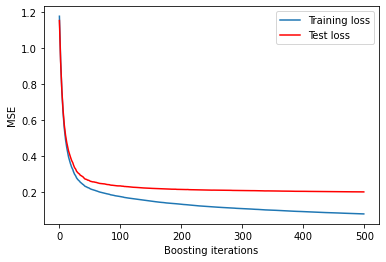

In [6]:
from sklearn.metrics import mean_squared_error as MSE

test_score = np.zeros(reg.n_estimators_)
for i, y_test_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = MSE(y_test, y_test_pred)
    
plt.plot(np.arange(reg.n_estimators), reg.train_score_, label='Training loss')
plt.plot(np.arange(reg.n_estimators), test_score, 'r', label='Test loss')

plt.xlabel('Boosting iterations')
plt.ylabel('MSE')

plt.legend()
plt.savefig('figures/california_gbr_learning_curve.pdf')

Feature importances

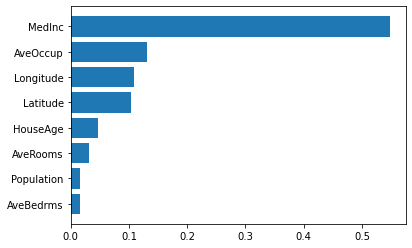

In [7]:
# Sort the features by their impotance
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot the feature importances
pos = np.arange(len(feature_importance))
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.xlabel('Feature importance')

plt.savefig('figures/california_gbr_feature_importance.pdf', bbox_inches='tight')